Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [3]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [4]:
xStart = np.linspace(5.65, 6.3, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [5]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-3, minStepSize = 1e-3
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

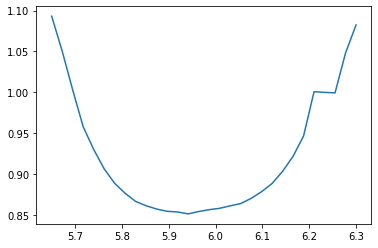

In [6]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [7]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    200, # Turn count
    nMax = 5, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 10,
    targetError = 1e-3, distanceLimit = 1e5,
    stellaratorSymmetric = True, aliasThreshold = 0.05
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [8]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [9]:
modes["iota"]

array([1.09004534, 1.0524724 , 1.00027693, 0.96020796, 0.93234772,
       0.90941869, 0.89128482, 0.87845799, 0.86941199, 0.86348427,
       0.85971877, 0.85709979, 0.8560228 , 0.85347304, 0.85460729,
       0.85649279, 0.85789905, 0.86050209, 0.86435138, 0.87003858,
       0.87795057, 0.88875986, 0.90337064, 0.9221343 , 0.94644469,
       1.00001664, 0.99996058, 1.0000052 , 1.04772229, 1.0824551 ])

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [10]:
surfaces = modes["surfaces"]

print(type(surfaces))
print("First:\n", surfaces[0])
print("Last:\n", surfaces[-1])
print("Average:\n", (surfaces[0] + surfaces[-1]) / 2)

<class 'fusionsc.magnetics.SurfaceArray'>
First:
 rCos:
  shape: [11, 6]
  data: [5.4188254442851687, 0.08972819364138182, 0.01083655670221979, -0.0028883159851889519, -0.00040098567329869552, 2.8652131432211888e-05, 0.11623491738865036, -0.045813339873693473, 0.0016836769663013235, 0.0013881217336125596, 0.0015630667110094287, -0.00069855944292550928, 0.013526558435193703, -0.00060632512527560489, 0.030079152702456705, -0.0014969835835247551, 0.0020049846336575778, 0.0015946290051566964, -0.0062730882458788308, 0.0027284921843019356, -0.0042245207685695308, -0.0069056845163537276, 0.0004589795283441855, -0.0018691908663396532, -0.0034491516427784352, 0.0005216975848490378, -2.7068322372797113e-05, 0.00036262073579484234, 0.00010596848128870127, 0.0011186394759032444, 0.003547415835825476, 0.00052123310957888889, -0.0023353888850699265, -0.00083880908375953407, -0.0015706488176492072, 0.0014916553076797302, 0, -0.0027689236455453242, -0.00016668697279524446, -0.00038658943451218167, -0

In [11]:
modes["theta"]

array([ 2.75524434e+00,  3.04028159e+00, -2.65494413e+00,  3.01110774e+00,
        3.00687786e+00,  3.04003853e+00,  3.02680244e+00,  3.02517663e+00,
        3.04347705e+00,  3.04478548e+00,  3.03754878e+00,  3.03208912e+00,
        3.04192230e+00,  3.01812180e+00, -1.03474838e-02,  3.04504560e-03,
       -1.42500420e-02, -2.47495142e-02, -6.85104940e-03,  1.86774116e-02,
       -6.19735289e-03, -1.39118227e-02,  9.66052704e-03,  1.57488067e-03,
       -2.72551899e-02,  5.39373336e-02, -1.80792571e-02, -1.89761564e-01,
       -1.57511253e-01, -4.42985582e-03])

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

(3, 30, 3, 100)


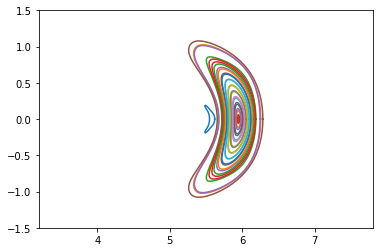

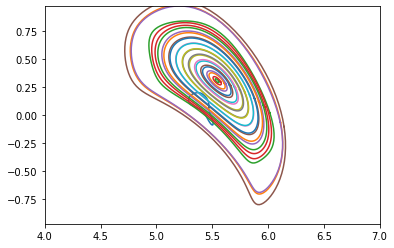

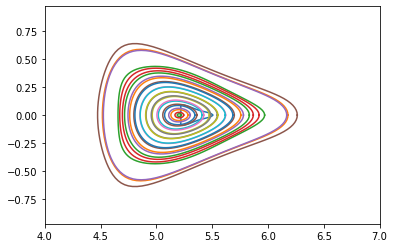

In [12]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces.evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, surfaces.shape[0]):
        if abs(modes['iota'][iSurf] - 1) < 0.02:
            continue
            
        dp = 1
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['thetaDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        plt.plot(r, z)
        #plt.quiver(r, z, dr, dz)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

C:\Daten\repos\fsc\src\python\fusionsc\_api_markers.py:15: UserWarning: The function fusionsc.magnetics.MagneticConfig.calculateRadialModes is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")


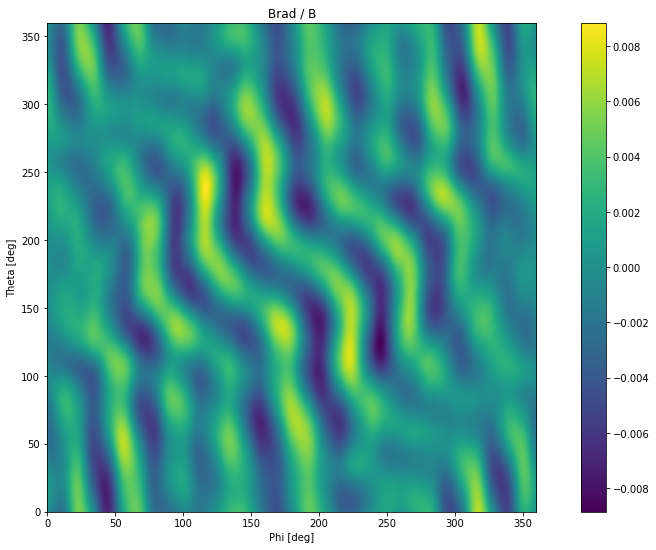

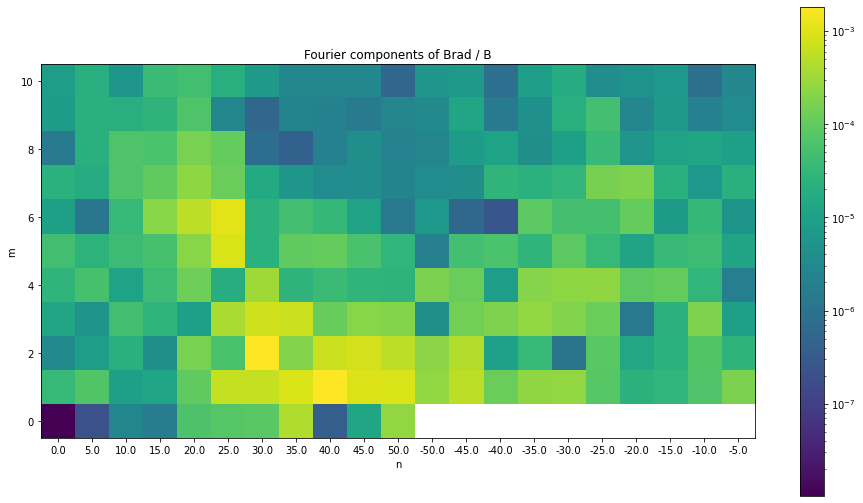

(250, 250)
n = 0, m = 0, val = 1.03e-08
n = 5, m = 0, val = 2.05e-07
n = 10, m = 0, val = 2.67e-06
n = 0, m = 1, val = 3.43e-05
n = 5, m = 1, val = 6.81e-05
n = 10, m = 1, val = 9.71e-06
n = 0, m = 2, val = 3.19e-06
n = 5, m = 2, val = 8.92e-06
n = 10, m = 2, val = 2.16e-05
n = 0, m = 3, val = 1.29e-05
n = 5, m = 3, val = 5.47e-06
n = 10, m = 3, val = 4.73e-05
n = 0, m = 4, val = 2.83e-05
n = 5, m = 4, val = 5.29e-05
n = 10, m = 4, val = 1.15e-05
n = 0, m = 5, val = 4.76e-05
n = 5, m = 5, val = 2.56e-05
n = 10, m = 5, val = 4.12e-05


In [13]:
surf = surfaces[6]
#np.asarray(surf.data.rCos)[0,0] += 0.03

fieldModes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 10, nMax = 10, nTheta = 250, nPhi = 250)
cc = fieldModes["cosCoeffs"]
sc = fieldModes["sinCoeffs"]

m = fieldModes["mPol"]
n = fieldModes["nTor"]

phi = fieldModes["phi"]
theta = fieldModes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(fieldModes["radialValues"].T, origin='lower', extent = [0, 360, 0, 360])
plt.colorbar()
plt.title("Brad / B")
plt.xlabel('Phi [deg]')
plt.ylabel('Theta [deg]')

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

print(fieldModes["radialValues"].shape)
for i_m, mVal in enumerate(m):
    for i_n, nVal in enumerate(n):
        if mVal > 5: continue
        if nVal < 0: continue
        if nVal > 10: continue
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")
